In [136]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# nest_asyncio allows async operations within the Juypeter Notebook
import nest_asyncio
nest_asyncio.apply()

### About Calibration of the Magnetometer

## Goals
- determine the heading of the robot
- the heading is primarily determind by the x,y plane
- the robot can physically only rotate about the z axis allowing for a calibration of the raw x,y values

## From the Magnetometer
- The magnetometer produces magnetic filed strengths in uT (micro tesla) for the x,y,z planes
- 9-DOF IMU sensor information for the MPU9250 North-East-Down(NED) as a fixed, parent coordinate system

## Hard-Iron Interference
- The raw x,y,z values are offset my unwanted magneic objects
- our goal is to recenter the raw vlaues x,y,z that there average on each plane is around zero
- this is done by calculating the needed offset and subtracting the offset

## Soft-Iron Interfereence 
- Nearby objects and structure of hte robot distort the magnetic field 
- our goal is to have a claibration that provides a compenstaion for this distortion

In [137]:
def plot_results_3d(title, raw_data, calibrated_data=None):
        """
        Plot the raw and calibrated magnetometer data in 3d.
        
        Args:
            raw_data: numpy.ndarray of raw magnetometer readings
            calibrated_data: numpy.ndarray of calibrated magnetometer readings (optional)
        """

        fig = plt.figure(figsize=(12, 6))
        
        # Plot raw data
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(raw_data[:, 0], raw_data[:, 1], raw_data[:, 2], c='r', marker='o', alpha=0.5)
        ax1.set_title(title+': Raw Magnetometer Data')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        
        # Make axes equal
        max_range = np.max([
            raw_data[:, 0].max() - raw_data[:, 0].min(),
            raw_data[:, 1].max() - raw_data[:, 1].min(),
            raw_data[:, 2].max() - raw_data[:, 2].min()
        ])
        mid_x = (raw_data[:, 0].max() + raw_data[:, 0].min()) / 2
        mid_y = (raw_data[:, 1].max() + raw_data[:, 1].min()) / 2
        mid_z = (raw_data[:, 2].max() + raw_data[:, 2].min()) / 2
        ax1.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
        ax1.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
        ax1.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
        
        # Plot calibrated data if provided
        if calibrated_data is not None:
            ax2 = fig.add_subplot(122, projection='3d')
            ax2.scatter(calibrated_data[:, 0], calibrated_data[:, 1], calibrated_data[:, 2], 
                    c='b', marker='o', alpha=0.5)
            ax2.set_title(title+' Calibrated Magnetometer Data')
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.set_zlabel('Z')
            
            # Make axes equal
            max_range = np.max([
                calibrated_data[:, 0].max() - calibrated_data[:, 0].min(),
                calibrated_data[:, 1].max() - calibrated_data[:, 1].min(),
                calibrated_data[:, 2].max() - calibrated_data[:, 2].min()
            ])
            mid_x = (calibrated_data[:, 0].max() + calibrated_data[:, 0].min()) / 2
            mid_y = (calibrated_data[:, 1].max() + calibrated_data[:, 1].min()) / 2
            mid_z = (calibrated_data[:, 2].max() + calibrated_data[:, 2].min()) / 2
            ax2.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
            ax2.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
            ax2.set_zlim(mid_z - max_range/2, mid_z + max_range/2)


        
        plt.tight_layout()
        plt.show()     

def plot_results_2d( title, raw_data, calibrated_data=None):
        """
        Plot the raw and calibrated magnetometer data in 2d alone the xy plane
        
        Args:
            raw_data: numpy.ndarray of raw magnetometer readings
            calibrated_data: numpy.ndarray of calibrated magnetometer readings (optional)
        """
    

        fig = plt.figure(figsize=(12, 6))
        
        # Plot raw data
        ax1 = fig.add_subplot(121)
        ax1.scatter(raw_data[:, 0], raw_data[:, 1], c='r', marker='o', alpha=0.5)
        ax1.set_title(title+': Raw Magnetometer Data xy plane')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')

        
        # Make axes equal
        max_range = np.max([
            raw_data[:, 0].max() - raw_data[:, 0].min(),
            raw_data[:, 1].max() - raw_data[:, 1].min()

        ])
        mid_x = (raw_data[:, 0].max() + raw_data[:, 0].min()) / 2
        mid_y = (raw_data[:, 1].max() + raw_data[:, 1].min()) / 2

        ax1.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
        ax1.set_ylim(mid_y - max_range/2, mid_y + max_range/2)

        ax1.axhline(0, color='red')
        ax1.axvline(0, color='red')

        
        # Plot calibrated data if provided
        if calibrated_data is not None:
            ax2 = fig.add_subplot(122)
            ax2.scatter(calibrated_data[:, 0], calibrated_data[:, 1], 
                    c='b', marker='o', alpha=0.5)
            ax2.set_title(title+': Calibrated Magnetometer Data XY plane')
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
        
            
            # Make axes equal
            max_range = np.max([
                calibrated_data[:, 0].max() - calibrated_data[:, 0].min(),
                calibrated_data[:, 1].max() - calibrated_data[:, 1].min(),
        
            ])
            mid_x = (calibrated_data[:, 0].max() + calibrated_data[:, 0].min()) / 2
            mid_y = (calibrated_data[:, 1].max() + calibrated_data[:, 1].min()) / 2

            ax2.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
            ax2.set_ylim(mid_y - max_range/2, mid_y + max_range/2)

            ax2.axhline(0, color='blue')
            ax2.axvline(0, color='blue')
        
        plt.tight_layout()
        plt.show()     

In [138]:


class MagnetometerCalibrator:
    """
    A class to calibrate magnetometer data by removing hard iron and soft iron distortions.
    
    Hard iron distortions are caused by permanent magnets and magnetized materials on the device
    and result in a constant offset in measurements.
    
    Soft iron distortions are caused by materials that distort the magnetic field but don't 
    generate a magnetic field themselves, resulting in scaling and rotation effects.
    """
    
    def __init__(self):
        # Calibration parameters
        self.hard_iron = np.zeros(3)  # Offset vector (hard iron)
        self.soft_iron_inv = np.eye(3)  # Inverse of the soft iron transformation matrix
        self.is_calibrated = False
    
    def collect_sample_data(self, duration_sec=60, sample_rate=10):
        """
        Function to collect sample data for calibration by rotating the device in a figure-8 pattern.
        
        In a real application, this would interface with your magnetometer hardware.
        For demonstration, this returns simulated data.
        
        Args:
            duration_sec: Duration in seconds to collect data
            sample_rate: Sample rate in Hz
            
        Returns:
            numpy.ndarray: Array of magnetometer readings with shape (n_samples, 3)
        """
        print(f"Please rotate your device in a figure-8 pattern for {duration_sec} seconds...")
        print("This is a simulation, so generating synthetic data...")
        
        # For simulation: generate points on a distorted sphere
        n_samples = duration_sec * sample_rate
        
        # True magnetic field magnitude (arbitrary units for simulation)
        true_field_magnitude = 50.0
        
        # Generate points on a sphere (ideally, magnetometer readings form a sphere)
        phi = np.random.uniform(0, 2*np.pi, n_samples)
        theta = np.random.uniform(0, np.pi, n_samples)
        
        x = true_field_magnitude * np.sin(theta) * np.cos(phi)
        y = true_field_magnitude * np.sin(theta) * np.sin(phi)
        z = true_field_magnitude * np.cos(theta)
        
        # Stack into an array
        ideal_data = np.column_stack((x, y, z))
        
        # Add simulated hard iron distortion (offset)
        hard_iron_offset = np.array([10.0, -7.5, 5.0])
        
        # Add simulated soft iron distortion (scaling and rotation)
        soft_iron_matrix = np.array([
            [0.9, 0.05, 0.02],
            [0.05, 1.1, -0.03],
            [0.02, -0.03, 0.9]
        ])
        
        # Apply distortions to our ideal data
        distorted_data = ideal_data @ soft_iron_matrix.T + hard_iron_offset
        
        # Add some noise
        noise = np.random.normal(0, 1.0, distorted_data.shape)
        distorted_data += noise
        
        return distorted_data
    
    def collect_raw_data(self):
        raw_data = genfromtxt('./magdata.csv', delimiter=',')
        return raw_data


    
    def calibrate(self, data):
        """
        Calibrate the magnetometer using collected data.
        
        Args:
            data: numpy.ndarray of shape (n_samples, 3) containing magnetometer readings
            
        Returns:
            bool: True if calibration was successful
        """
        if data.shape[1] != 3:
            raise ValueError("Data must have shape (n_samples, 3)")
        
        print("Starting calibration process...")
        
        # Define the objective function to minimize
        def objective_function(params):
            # Extract parameters
            offset_x, offset_y, offset_z = params[0:3]
            w1, w2, w3, w4, w5, w6, w7, w8, w9 = params[3:12]
            
            # Construct matrices
            offset = np.array([offset_x, offset_y, offset_z])
            soft_iron = np.array([
                [w1, w2, w3],
                [w2, w4, w5],
                [w3, w5, w6]
            ])
            
            # Apply calibration to the data
            calibrated = (data - offset) @ soft_iron
            
            # Calculate the magnitude of each calibrated reading
            magnitudes = np.linalg.norm(calibrated, axis=1)
            
            # The objective is to have a consistent magnitude (sphere)
            # We minimize the variance of the magnitudes
            return np.var(magnitudes)
        
        # Initial guess - identity for soft iron, zeros for hard iron offset
        initial_params = np.array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])
        
        # Perform optimization
        result = minimize(objective_function, initial_params, method='Powell')
        
        if result.success:
            # Extract optimized parameters
            offset_x, offset_y, offset_z = result.x[0:3]
            w1, w2, w3, w4, w5, w6, w7, w8, w9 = result.x[3:12]
            
            self.hard_iron = np.array([offset_x, offset_y, offset_z])
            self.soft_iron_inv = np.array([
                [w1, w2, w3],
                [w2, w4, w5],
                [w3, w5, w6]
            ])
            
            self.is_calibrated = True
            print("Calibration successful!")
            print(f"Hard iron offset: {self.hard_iron}")
            print(f"Soft iron transformation matrix inverse:")
            print(self.soft_iron_inv)
            
            return True
        else:
            print("Calibration failed. Please try again with different data.")
            return False
    
    def apply_calibration(self, raw_data):
        """
        Apply the calibration to new magnetometer readings.
        
        Args:
            raw_data: numpy.ndarray of shape (n_samples, 3) containing raw magnetometer readings
            
        Returns:
            numpy.ndarray: Calibrated magnetometer readings
        """
        if not self.is_calibrated:
            raise RuntimeError("Calibration must be performed before applying it")
        
        # Apply hard iron and soft iron corrections
        return (raw_data - self.hard_iron) @ self.soft_iron_inv
    

              




### Application of Calibration

Using sample data in the x,y,z plane the claibration works beautifully ...

In [139]:
def calibraitonWithSampleData():
    """
    Main function to demonstrate the magnetometer calibration process.
    """
    # Create a calibrator instance
    calibrator = MagnetometerCalibrator()
    
    # Collect (simulated) data
    raw_data = calibrator.collect_sample_data(duration_sec=30, sample_rate=10)

    # Calibrate using the collected data    
    calibrator.calibrate(raw_data)
    
    # Apply the calibration to the same data (in real use, would be applied to new readings)
    calibrated_data = calibrator.apply_calibration(raw_data)
    
    # Plot results
    plot_results_3d("Sample",raw_data, calibrated_data)
    plot_results_2d("Sample",raw_data, calibrated_data)
    
    # Calculate and print statistics to show improvement
    raw_magnitudes = np.linalg.norm(raw_data, axis=1)
    cal_magnitudes = np.linalg.norm(calibrated_data, axis=1)
    
    print("\nCalibration Statistics:")
    print(f"Raw data magnitude: mean={raw_magnitudes.mean():.2f}, std={raw_magnitudes.std():.2f}")
    print(f"Calibrated data magnitude: mean={cal_magnitudes.mean():.2f}, std={cal_magnitudes.std():.2f}")
    print(f"Standard deviation improvement: {(1 - cal_magnitudes.std() / raw_magnitudes.std()) * 100:.2f}%")


# Run the demonstration if this file is executed directly
if __name__ == "__main__":
    calibraitonWithSampleData()

Please rotate your device in a figure-8 pattern for 30 seconds...
This is a simulation, so generating synthetic data...
Starting calibration process...
Calibration failed. Please try again with different data.


RuntimeError: Calibration must be performed before applying it

### The Dissapointment

However when real data is used for the magnetometer, where the robot just rotates around the 
Z-axis the results are dissapointing ...

We can see from the real raw magnetometer data, that ther eis little deviation on the z-axis, and 
the x-axis, y-axis, mainly provide values of interest

The Real calibrated magnetometer data is unusable.

Starting calibration process...
Calibration successful!
Hard iron offset: [-3.74937550e+01  2.84827448e+04 -7.75256998e+07]
Soft iron transformation matrix inverse:
[[ 1.01313380e-03 -4.55490908e-03 -8.99390017e-05]
 [-4.55490908e-03  2.04534608e-02 -1.21113528e-05]
 [-8.99390017e-05 -1.21113528e-05 -3.73497564e-08]]


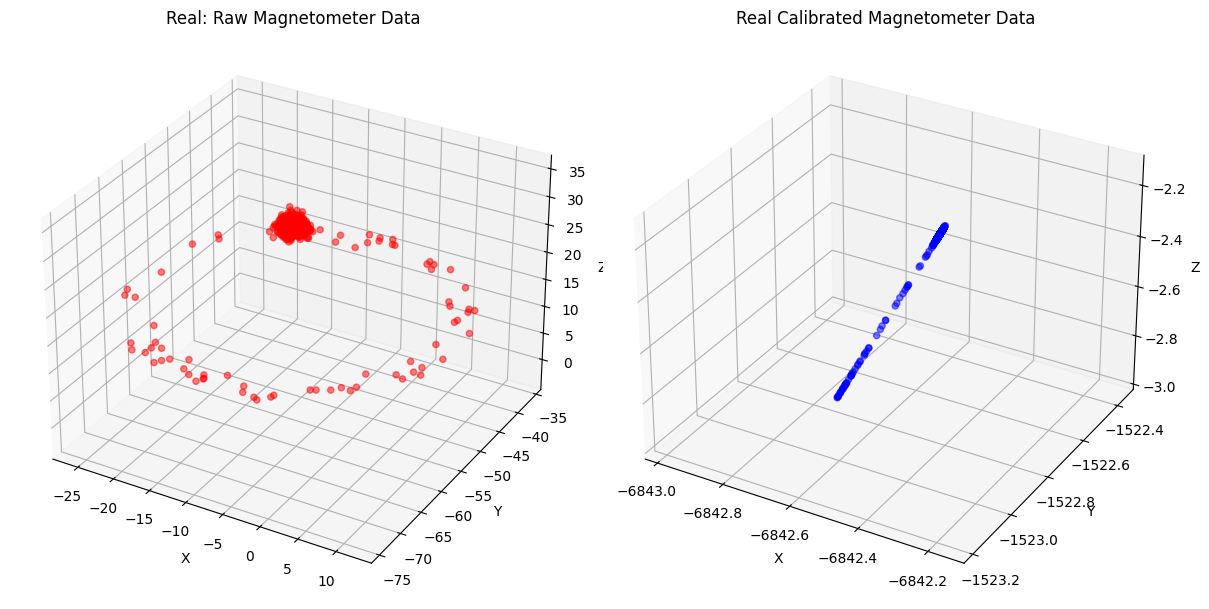

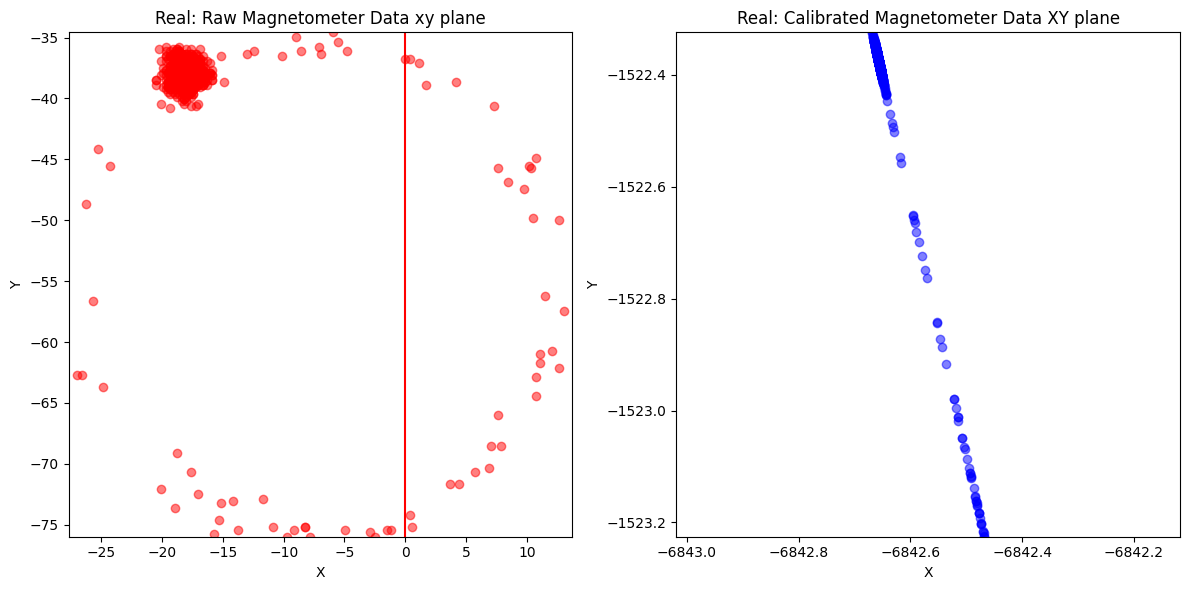


Calibration Statistics:
Raw data magnitude: mean=46.15, std=6.27
Calibrated data magnitude: mean=7009.96, std=0.00
Standard deviation improvement: 100.00%


In [ ]:
def calibraitonWithRealData():
    """
    Main function to demonstrate the magnetometer calibration process.
    """
    # Create a calibrator instance
    calibrator = MagnetometerCalibrator()
    
    
    # Collect (real) data
    raw_data = calibrator.collect_raw_data()
    
    # Calibrate using the collected data
    calibrator.calibrate(raw_data)
    
    # Apply the calibration to the same data (in real use, would be applied to new readings)
    calibrated_data = calibrator.apply_calibration(raw_data)
    
    # Plot results
    plot_results_3d("Real",raw_data, calibrated_data)
    plot_results_2d("Real",raw_data, calibrated_data)
    
    # Calculate and print statistics to show improvement
    raw_magnitudes = np.linalg.norm(raw_data, axis=1)
    cal_magnitudes = np.linalg.norm(calibrated_data, axis=1)
    
    print("\nCalibration Statistics:")
    print(f"Raw data magnitude: mean={raw_magnitudes.mean():.2f}, std={raw_magnitudes.std():.2f}")
    print(f"Calibrated data magnitude: mean={cal_magnitudes.mean():.2f}, std={cal_magnitudes.std():.2f}")
    print(f"Standard deviation improvement: {(1 - cal_magnitudes.std() / raw_magnitudes.std()) * 100:.2f}%")


# Run the demonstration if this file is executed directly
if __name__ == "__main__":
    calibraitonWithRealData()

In [ ]:

########################################
# Calibrate Magnetometer Async Task
def calibrateMagTask(raw_data) -> tuple:
        '''
        create magnetometer bias, normailization and scaling
        this is perferformed while the magnetomer is rotating around all axes
        '''
        
        print('starting calibrateMagTask')

        samples = len(raw_data)
        pointer = 0

        # initilaize the varaible with the first set of data
        x,y,z = raw_data[pointer]
        minx = x
        maxx = x
        miny = y
        maxy = y
        minz = z
        maxz = z

        # from the raw data determin the maximum and minima in each plane x y z
        while pointer < samples :
                
                x,y,z = raw_data[pointer]
                pointer = pointer +1
        
                # determin the min and max value on each plane
                minx = min(x,minx)
                maxx = max(x,maxx)
                miny = min(y,miny)
                maxy = max(y,maxy)
                minz = min(z,minz)
                maxz = max(z,maxz)
                

        # Calculate hard iron offsets (center of min/max for each axis)
        cx = (maxx + minx) / 2
        cy = (maxy + miny) / 2  
        cz = (maxz + minz) / 2  



        # Calculate soft iron scaling (scale each axis to spherical)
        avg_delta = ( (maxx - minx) +  (maxy - miny) +  (maxz - minz) ) / 3
        sx = avg_delta / (maxx - minx) if maxx != minx else 1
        sy = avg_delta / (maxy - miny) if maxy != miny else 1
        sz = avg_delta / (maxz - minz) if maxz != minz else 1

        # Factors to normailze the data in a range -1..1
        nx = abs(maxx - cx)
        ny = abs(maxy - cy)
        nz = abs(maxz - cz)

        print("center bias",cx,cy,cz)
        print("normalisation",nx,ny,nz)
        print("scale",sx,sy,sz)

        # update the magbias
        #store.magbias = (cx, cy, cz ,nx, ny, nz, sx, sy, sz) 

        return cx, cy, cz, sx, sy, sz, nx, ny, nz
 


In [ ]:
def read_calibrated_data(bias=(0,0,0,1,1,1,1,1,1) ):
    """
    return tuple of magnetometer measurements (x,y,z)
    North-East-Down(NED) as a fixed, parent coordinate system      
    """

    print('starting readMag with bias',bias)

    raw_data = genfromtxt('./magdata.csv', delimiter=',')

    samples = len(raw_data)
    pointer = 0

    calibrated_data = []

    while pointer < samples :            
            x,y,z = raw_data[pointer]
            pointer = pointer +1

            # apply hard-iron offset
            x,y,z = x - bias[0], y - bias[1], z - bias[2]

            # apply soft-iron scale
            x,y,z = x * bias[3], y * bias[4], z * bias[5]

            # apply normalize
            x,y,z = x / bias[6], y / bias[7], z / bias[8]

            calibrated_data.append([x,y,z])

    return calibrated_data

starting calibrateMagTask
center bias -6.984999999999999 -55.275000000000006 15.843499999999999
normalisation 20.005 20.705000000000005 2.4375
scale 0.7189452636840791 0.6946389760927312 5.900512820512823
calibration (-6.984999999999999, -55.275000000000006, 15.843499999999999, 20.005, 20.705000000000005, 2.4375, 0.7189452636840791, 0.6946389760927312, 5.900512820512823)
starting readMag with bias (-6.984999999999999, -55.275000000000006, 15.843499999999999, 20.005, 20.705000000000005, 2.4375, 0.7189452636840791, 0.6946389760927312, 5.900512820512823)


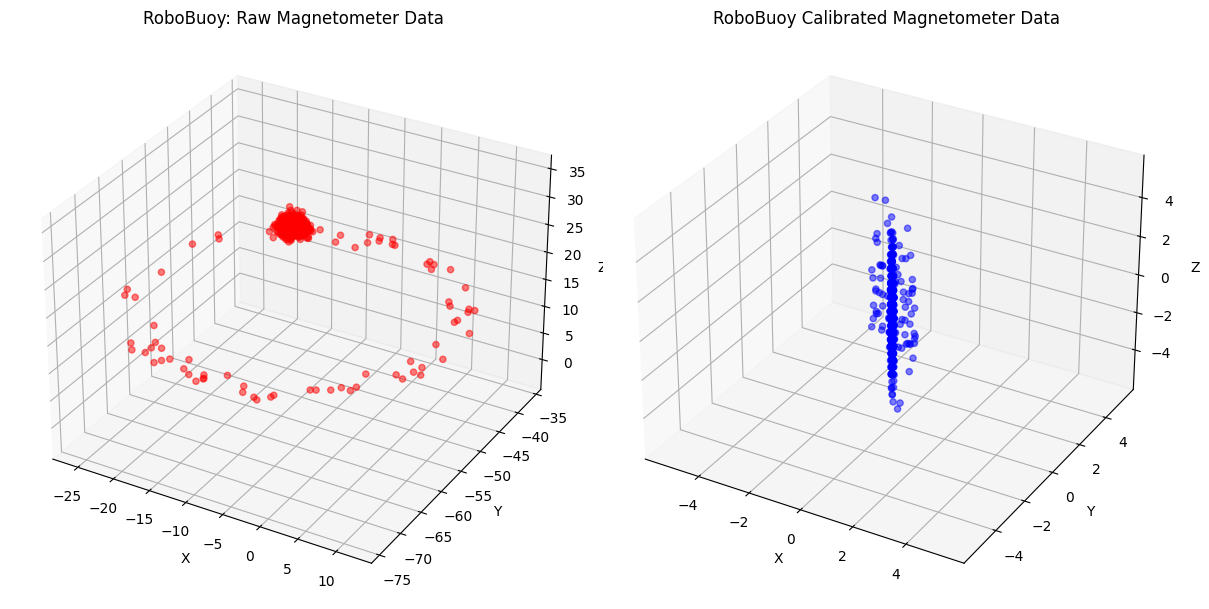

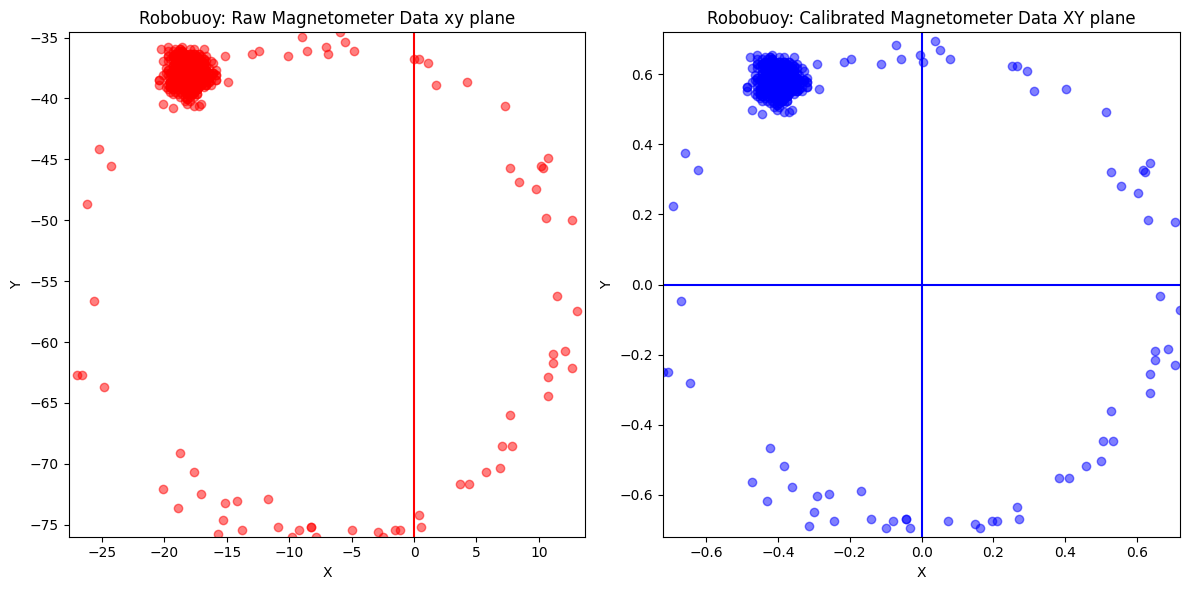

In [ ]:


def theRoboBouyWay():

    # Calibrate with the raw-data
    raw_data = genfromtxt('./magdata.csv', delimiter=',')

    calibration = calibrateMagTask(raw_data)

    print('calibration',calibration)

    # Using the claibration get calibrated data
    calibrated_data = read_calibrated_data(calibration)

    # convert to a numpy array for plotting
    np_raw_data = np.array([np.array(xi) for xi in raw_data])
    np_calibrated_data = np.array([np.array(xi) for xi in calibrated_data])

    #plot the 3D and 2D Reults
    plot_results_3d("RoboBuoy",np_raw_data,np_calibrated_data)
    plot_results_2d("Robobuoy",np_raw_data,np_calibrated_data)

# Run the demonstration if this file is executed directly
if __name__ == "__main__":
    theRoboBouyWay()